DCGAN or Deep Convolutional GAN, is a generative adversarial network architecture. It uses a couple of guidelines. In particular:



*   Replacing any pooling layers with the strided convolutions (discriminator) and fractional-strided convolutions (generators)

*   Using bathnorm in both generator and discriminator
*   Removing fully connected hiiden layers for deeper architecture


*   Using ReLU activation in generator for all lyers except for the output which uses tanh


*   Using LeakyReLu activation in the discriminator for all layers

this is the source : https://paperswithcode.com/method/dcgan#:~:text=DCGAN%2C%20or%20Deep%20Convolutional%20GAN,the%20generator%20and%20the%20discriminator.



In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Conv2DTranspose, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


In [2]:
img_dims = 28
img_chn1 = 1
ltnt_dim=100
(x_train,y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (60000, 28, 28, 1)
x_test shape:  (10000, 28, 28, 1)


In [4]:
# we will build the generator convolutional neural network
inpt_noise = Input(shape=(ltnt_dim))
g11 = Dense(7*7*256, activation='relu')(inpt_noise)
g12 = BatchNormalization()(g11)
g13 = Reshape((7,7,256))(g12)
g14= Conv2DTranspose(128, (5,5), strides=(1,1),padding='same', activation='relu')(g13)
g15 = BatchNormalization()(g14)
g16= Conv2DTranspose(64, (5,5), strides=(2,2),padding='same', activation='relu')(g15)
g17 = BatchNormalization()(g16)
g18= Conv2DTranspose(1, (5,5), strides=(2,2),padding='same', activation='sigmoid')(g17)
generator = Model(inpt_noise, g18)
gnrtr_img = generator(inpt_noise)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512   

In [5]:
#build the critic convolutional network
inpt_img = Input(shape=(img_dims,img_dims, img_chn1 ))
d11 = Conv2D(64,(5,5), strides=(2,2), padding='same', activation='relu')(inpt_img)
d12= Dropout(0.3)(d11)

d13 = Conv2D(128,(5,5), strides=(2,2), padding='same', activation='relu')(d12)
d14= Dropout(0.3)(d13)

d15 = Flatten()(d14)
d16= Dense(1,activation='sigmoid')(d15)
critic = Model(inpt_img, d16)
validity = critic(gnrtr_img)
critic.summary() # critic = discriminator

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273

In [6]:
optimizer = Adam(0.0002, 0.5)

critic.compile(loss='binary_crossentropy', optimizer=optimizer, 
               metrics=['accuracy'])

critic.trainable = False

gen_crt = Model(inpt_noise, validity)
gen_crt.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 12001
batch_size=64
sample_interval=400

In [7]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

samp_imgs = {}
closs = []
gloss = []
cacc = []
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  gen_imgs = generator.predict(noise)
  c_loss_real = critic.train_on_batch(imgs, valid)
  c_loss_fake = critic.train_on_batch(gen_imgs, fake)
  c_loss = 0.5 * np.add(c_loss_real, c_loss_fake)

  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  g_loss = gen_crt.train_on_batch(noise, valid)
  
  closs.append(c_loss[0])
  cacc.append(c_loss[1])
  gloss.append(g_loss)

  if epoch % sample_interval == 0:
    print ("%d [C loss: %f, acc.: %.2f%%] [G loss: %f]" % 
           (epoch, c_loss[0], 100*c_loss[1], g_loss))
  
    noise = np.random.uniform(0, 1, (2, ltnt_dim))
    gen_imgs = generator.predict(noise)
    samp_imgs[epoch] = gen_imgs 

0 [C loss: 0.713574, acc.: 19.53%] [G loss: 0.692769]
400 [C loss: 0.000325, acc.: 100.00%] [G loss: 0.000171]
800 [C loss: 0.127670, acc.: 95.31%] [G loss: 0.083617]
1200 [C loss: 0.644708, acc.: 62.50%] [G loss: 0.891554]
1600 [C loss: 0.628254, acc.: 64.84%] [G loss: 0.816300]
2000 [C loss: 0.667770, acc.: 58.59%] [G loss: 0.819905]
2400 [C loss: 0.683302, acc.: 53.91%] [G loss: 0.824737]
2800 [C loss: 0.648944, acc.: 60.94%] [G loss: 0.761042]
3200 [C loss: 0.685433, acc.: 53.12%] [G loss: 0.744786]
3600 [C loss: 0.674860, acc.: 60.16%] [G loss: 0.726794]
4000 [C loss: 0.688900, acc.: 53.12%] [G loss: 0.693323]
4400 [C loss: 0.674811, acc.: 55.47%] [G loss: 0.743246]
4800 [C loss: 0.683949, acc.: 57.81%] [G loss: 0.755016]
5200 [C loss: 0.682131, acc.: 53.91%] [G loss: 0.748628]
5600 [C loss: 0.673636, acc.: 60.16%] [G loss: 0.754416]
6000 [C loss: 0.699743, acc.: 50.78%] [G loss: 0.722034]
6400 [C loss: 0.687192, acc.: 56.25%] [G loss: 0.762869]
6800 [C loss: 0.669246, acc.: 60.16

The above result can  look different in your laptop or computer because this is all based on random noise. This randomness aspect will take your model in a different direction. However,  what you will see is that your generator's loss will decrease dradually and if the generator works properly, the accuracy should be geetting closer to random change, that is close to 50%. If your discriminator is always 100% then your generator is not good enough, and if your dicriminator is around 50% accuracy, then your generator might be too good or discrimitor is too weak.

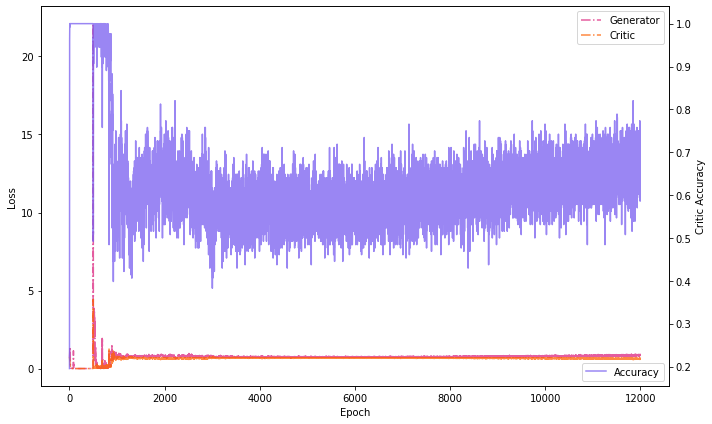

In [8]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(epochs), gloss, '-.', color='#dc267f', alpha = 0.75, label='Generator')
ax1.plot(range(epochs), closs, '-.', color='#fe6100', alpha = 0.75, label='Critic')
ax1.legend(loc=1)
ax2 = ax1.twinx()

ax2.set_ylabel('Critic Accuracy')
ax2.plot(range(epochs), cacc, color='#785ef0', alpha = 0.75, label='Accuracy')
ax2.legend(loc=4)

fig.tight_layout()
plt.show()

The plot above shows the loss of generator and discriminator across all epochs. It also shows the accuracy accross epochs.

As can be seen from the above plot, the loss of the discriminator is very low, as also indicated by the accuracy. But as epochs afvance, the generator get better (due to decrease in losss) and also accuracy is varied, but the general trend of the accuracy slightly decreases. The final accuracy is about 70-80% which is very good.

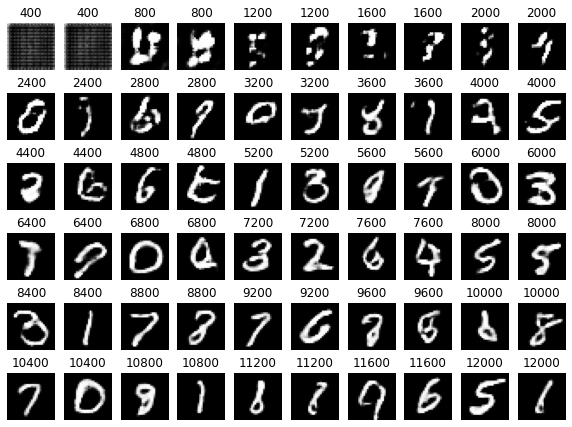

In [11]:
# Display some of the images 
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 10, figsize=(10,7.5))
cnt = sample_interval
for i in range(6):
 for j in [0, 2, 4, 6, 8]:
   img = samp_imgs[cnt]
   axs[i,j].imshow(img[0,:,:,0], cmap='gray')
   axs[i,j].axis('off')
   axs[i,j].set_title(cnt)
   axs[i,j+1].imshow(img[1,:,:,0], cmap='gray')
   axs[i,j+1].axis('off')
   axs[i,j+1].set_title(cnt)
   cnt += sample_interval
plt.show()


There is something we can take from this model.

The first one is the model needs to be improved if the model is larger.

The second one is if what we need is a good generator we can extend the generator or change it into the convolutional one.

The next one is we can save the discriminator and retrain it (fine-tune it) for the classification of digits.


The final one is we can use generator to augment the dataset with as many images as we want.